<h1 align="center">Introduction to Machine Learning - Course Code: 25737</h1>
<h4 align="center">Instructor: Dr. Amiri</h4>
<h4 align="center">Sharif University of Technology, Spring 2024</h4>
<h4 align="center">Computer Assignment 3</h4>
<h4 align="center">

Question 3

</h4>

# Personal Data

In [2]:
# Set your student number
student_number = 400101283
Name = 'Kimia'
Last_Name = 'Ramezan'

In [3]:
"""
AUTHOR:         Ahmad Salimi (https://github.com/ahmadsalimi)
"""


from typing import Tuple

from sklearn.datasets import fetch_openml
import numpy as np
import os
import torch
from tqdm import tqdm


def get_data() -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """ Downloads the MNIST data and processes the data for autoencoder problem.

    Returns:
        Tuple[np.ndarray, np.ndarray, np.ndarray]: A tuple of input images,
            output images (input + 1), and the label of input images
    """
    X, y = fetch_openml('mnist_784', return_X_y=True, cache=True)
    X, y = X.values, y.values
    X = X.reshape(-1, 28, 28).astype('float32') / 255.0
    y = y.astype(int)

    Y = np.zeros_like(X)
    ind = y.argsort()
    X, y = X[ind], y[ind]

    c = 0
    for i in range(10):
        s = (y == i).sum()
        ss = (y == (i + 1) % 10).sum()
        if s <= ss:
            Y[c:c+s] = X[c+s:c+2*s]
        elif i < 9:
            Y[c:c+ss] = X[c+s:c+s+ss]
            Y[c+ss:c+s] = X[c+s:c+2*s-ss]
        else:
            Y[c:c+ss] = X[:ss]
            Y[c+ss:c+s] = X[:s-ss]
        c += s

    current_state = np.random.get_state()

    np.random.seed(10)
    ind = np.random.permutation(X.shape[0])
    X, Y, y = X[ind], Y[ind], y[ind]

    np.random.set_state(current_state)

    return X, Y, y

def init_mnist_subset_directories(mnist_dataset, dataset_path, subset_size=5000):
    mnist_subset = torch.utils.data.Subset(mnist_dataset, torch.randperm(len(mnist_dataset))[:subset_size])

    os.mkdir(dataset_path)

    for idx, (x, y) in enumerate(tqdm(mnist_subset)):
        label_path = os.path.join(dataset_path, str(y))
        if not os.path.exists(label_path):
            os.mkdir(label_path)
        torch.save(x, os.path.join(label_path, 'data_'+str(idx)+'.pth'))


# Autoencoders (25 Points)

In this problem, you should implement an autoencoder network, which generates an image presenting the next digit of the input digit. Here are some examples:

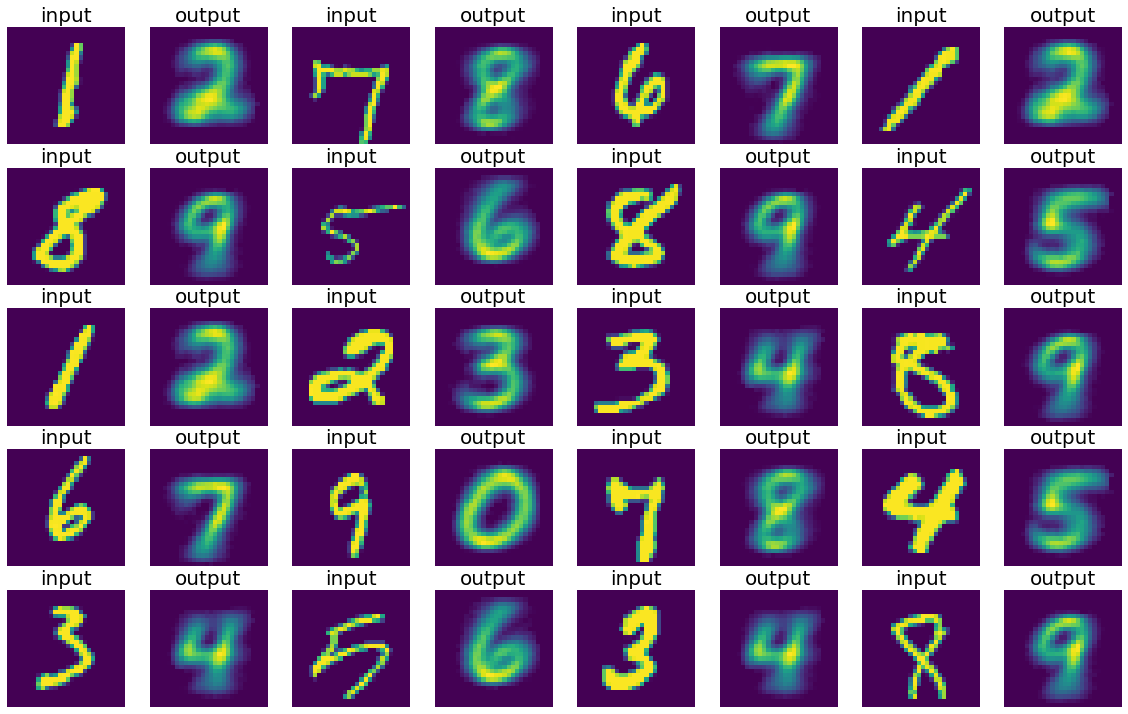

You should use the MNIST dataset, and the ground-truth for each example is provided by a helper function. Make sure to put the `ae_helper.py` file next to this notebook to use the helper function.

## Get the data

Get the data and split them into training, validation, and test sets, by running the following cell. `X` is the input images, `Y` is the ground-truth for each input, and `y` is the input's label.

In [4]:
from sklearn.model_selection import train_test_split

X, Y, y = get_data()

X_train, X_test, Y_train, Y_test, y_train, y_test = train_test_split(X, Y, y, test_size=0.2, random_state=17)
X_train, X_val, Y_train, Y_val, y_train, y_val = train_test_split(X_train, Y_train, y_train, test_size=0.1, random_state=17)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


## Design your model

Please Implement your autoencoder model below. You MUST implement your model using the `torch` package. The model should input a batch of images and output the generated images for the whole batch. Your model can be consist of fully connected layers (using linear layers), but using fully-convolutional models has extra points.

In [5]:
#### IMPLEMENT YOUR MODEL ####
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.nn import functional as F
from torch.optim import lr_scheduler

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  # [batch, 1, 28, 28] -> [batch, 16, 14, 14]
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),  # [batch, 16, 14, 14] -> [batch, 32, 7, 7]
            nn.ReLU(True),
            nn.Conv2d(32, 64, 7)  # [batch, 32, 7, 7] -> [batch, 64, 1, 1]
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),  # [batch, 64, 1, 1] -> [batch, 32, 7, 7]
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),  # [batch, 32, 7, 7] -> [batch, 16, 14, 14]
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),  # [batch, 16, 14, 14] -> [batch, 1, 28, 28]
            nn.Sigmoid()  # To ensure output is between 0 and 1
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.encoder(x)
        x = self.decoder(x)
        return x


## The dataset class, and the dataloaders

The following cells implement the dataset class and create the data loaders for training and validation sets. Feel free to modify the batch size for each data loader.

In [6]:
from typing import Tuple
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class MnistNextDigitDataset(Dataset):
    def __init__(self, X: np.ndarray, Y: np.ndarray, y: np.ndarray):
        self.X = torch.from_numpy(X)
        self.Y = torch.from_numpy(Y)
        self.y = torch.from_numpy(y)

    def __len__(self) -> int:
        return self.X.shape[0]

    def __getitem__(self, i: int) -> Tuple[torch.Tensor, ...]:
        return self.X[i], self.Y[i], self.y[i]

In [7]:
train_dataloader = DataLoader(
    MnistNextDigitDataset(X_train, Y_train, y_train),
    batch_size=512,
    shuffle=True
)
val_dataloader = DataLoader(
    MnistNextDigitDataset(X_val, Y_val, y_val),
    batch_size=1024,
    shuffle=False
)

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

def train_autoencoder(model: nn.Module, optimizer: torch.optim.Optimizer, scheduler, dataloader: DataLoader) -> float:
    model.train()
    epoch_loss = 0.0
    criterion = nn.MSELoss()

    for data in dataloader:
        img, Y, y = data  # img is the input image, _ is the label
        # Forward pass
        output = model(img.to(device).unsqueeze(1))
        loss = criterion(output.squeeze(), Y)  # Compare output to input

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * img.size(0)

    scheduler.step()

    return epoch_loss / len(dataloader.dataset)


def eval_autoencoder(model: nn.Module, dataloader: DataLoader) -> float:
    model.eval()
    epoch_loss = 0.0
    criterion = nn.MSELoss()

    with torch.no_grad():
        for data in dataloader:
            img, Y, y = data  # img is the input image, _ is the label

            # Forward pass
            output = model( img.to(device).unsqueeze(1))
            loss = criterion(output.squeeze(), Y)  # Compare output to input

            epoch_loss += loss.item() * img.size(0)

    return epoch_loss / len(dataloader.dataset)


cpu


## Instantiate the model and optimizer

Instantiate your model and optimizer in the following cell. Feel free to choose the optimizer and its configurations such as learning rate, decay, etc.

In [9]:
#### INSTANTIATE YOUR MODEL AND OPTIMIZER ####
ae = AutoEncoder().to(device=device)
optimizer = torch.optim.Adam(ae.parameters(), lr=0.001)  # Adjusted learning rate
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

## Train your autoencoder

Write your training/validation loop in the following cell for an arbitrary number of epochs (until convergence is detected). Make sure to use proper and readable logging containing training and validation metrics for each epoch. Select and store the state dictionary of the best epoch model according to the metrics.

In [10]:
import numpy as np

num_epochs = 20
best_val_loss = np.inf
best_epoch = 0
best_model_state = None

for epoch in range(num_epochs):

    train_loss = train_autoencoder(ae, optimizer,scheduler, train_dataloader)


    val_loss = eval_autoencoder(ae, val_dataloader)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
        best_model_state = ae.state_dict().copy()


print(f'Best model found at epoch {best_epoch+1}, with validation loss: {best_val_loss:.4f}')

ae.load_state_dict(best_model_state)

Epoch [1/20], Train Loss: 0.0963, Val Loss: 0.0681
Epoch [2/20], Train Loss: 0.0677, Val Loss: 0.0672
Epoch [3/20], Train Loss: 0.0664, Val Loss: 0.0651
Epoch [4/20], Train Loss: 0.0633, Val Loss: 0.0618
Epoch [5/20], Train Loss: 0.0607, Val Loss: 0.0599
Epoch [6/20], Train Loss: 0.0595, Val Loss: 0.0593
Epoch [7/20], Train Loss: 0.0590, Val Loss: 0.0589
Epoch [8/20], Train Loss: 0.0586, Val Loss: 0.0585
Epoch [9/20], Train Loss: 0.0582, Val Loss: 0.0581
Epoch [10/20], Train Loss: 0.0579, Val Loss: 0.0579
Epoch [11/20], Train Loss: 0.0577, Val Loss: 0.0577
Epoch [12/20], Train Loss: 0.0575, Val Loss: 0.0576
Epoch [13/20], Train Loss: 0.0574, Val Loss: 0.0574
Epoch [14/20], Train Loss: 0.0573, Val Loss: 0.0573
Epoch [15/20], Train Loss: 0.0572, Val Loss: 0.0573
Epoch [16/20], Train Loss: 0.0571, Val Loss: 0.0572
Epoch [17/20], Train Loss: 0.0570, Val Loss: 0.0571
Epoch [18/20], Train Loss: 0.0570, Val Loss: 0.0571
Epoch [19/20], Train Loss: 0.0569, Val Loss: 0.0570
Epoch [20/20], Train 

<All keys matched successfully>

## Load the state dictionary of the best epoch

Load the state dictionary of the best epoch model into the model object.

In [11]:
best_ae = AutoEncoder().to(device=device)
best_ae.load_state_dict(best_model_state)

<All keys matched successfully>

## Visualize your model

Select 40 examples from the test set and visualize the input and output of the model for them (See the examples at the beginning of the notebook).

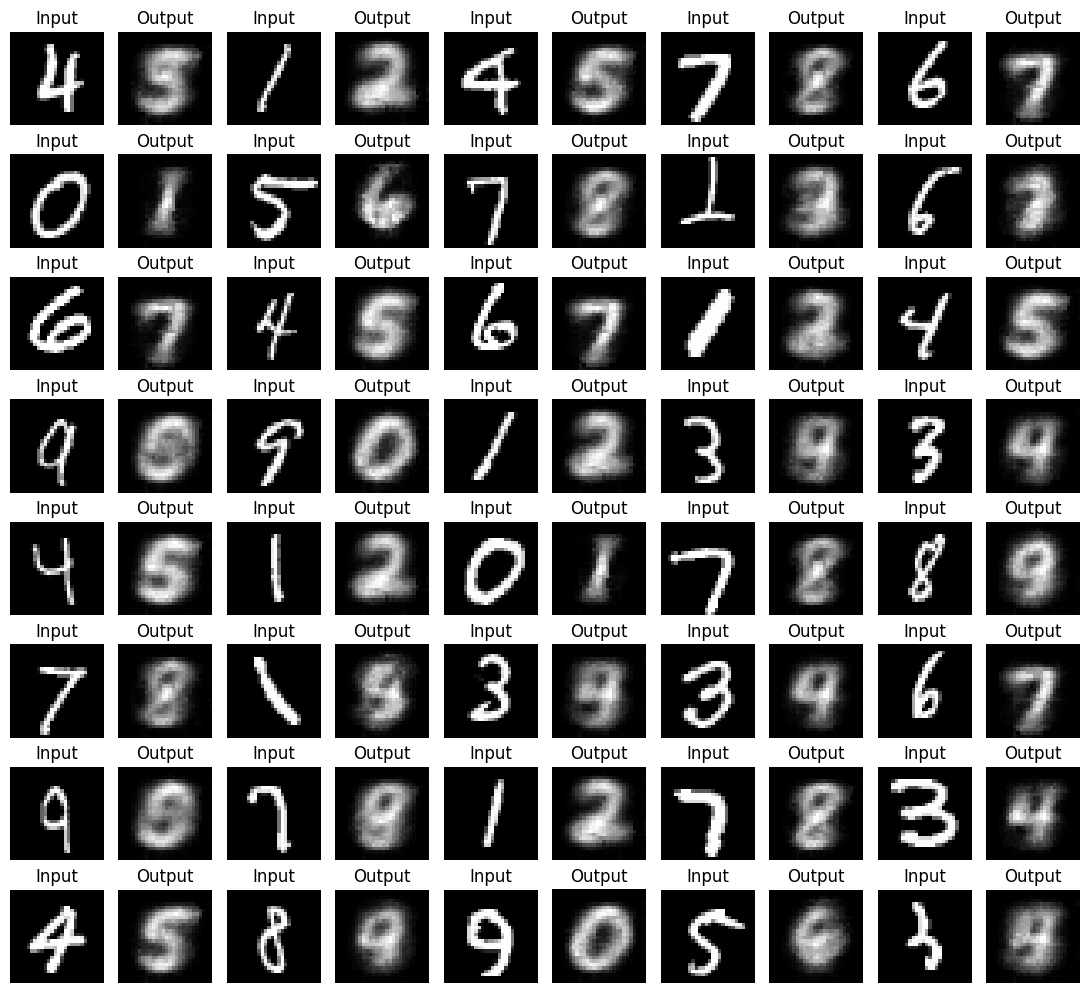

In [15]:
import matplotlib.pyplot as plt

best_ae.eval()

selected_indices = np.random.choice(len(X_test), 40, replace=False)

selected_X_tensor = torch.tensor(X_test[selected_indices]).unsqueeze(1).to(device)

with torch.no_grad():
    reconstructed_output = best_ae(selected_X_tensor)

plt.figure(figsize=(11,10))

for i in range(40):
    plt.subplot(8,10,2 * i + 1)
    plt.imshow(selected_X_tensor[i, 0].cpu().numpy(), cmap='gray')  # Input
    plt.axis('off')
    plt.title('Input')

    plt.subplot(8,10,2*i+2)
    plt.imshow(reconstructed_output[i, 0].cpu().numpy(), cmap='gray')  # Output
    plt.axis('off')
    plt.title('Output')

plt.tight_layout()
plt.show()
